# Siesmic Reverse Time Migration
Saleh Al Nasser, Geophysics EAPS



# Supermarket Acquistion System 
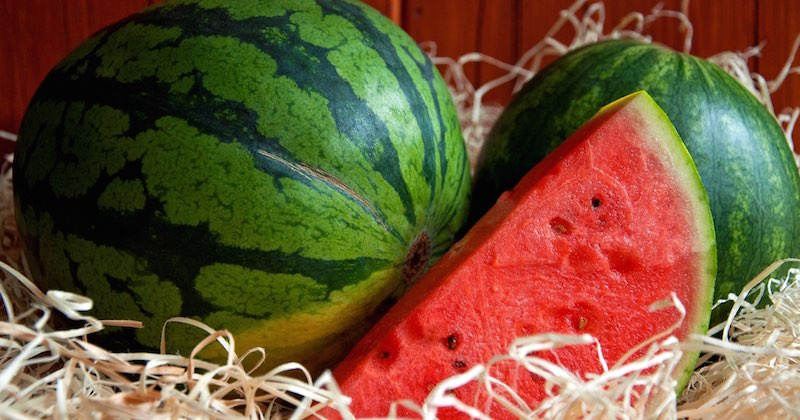

# Land Seismic Acquisition System

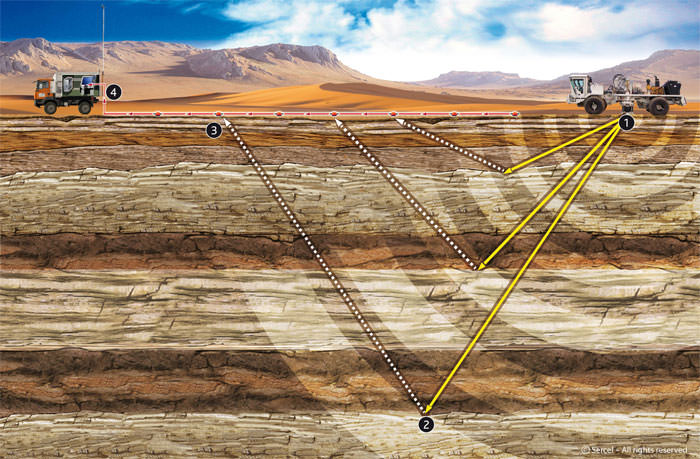

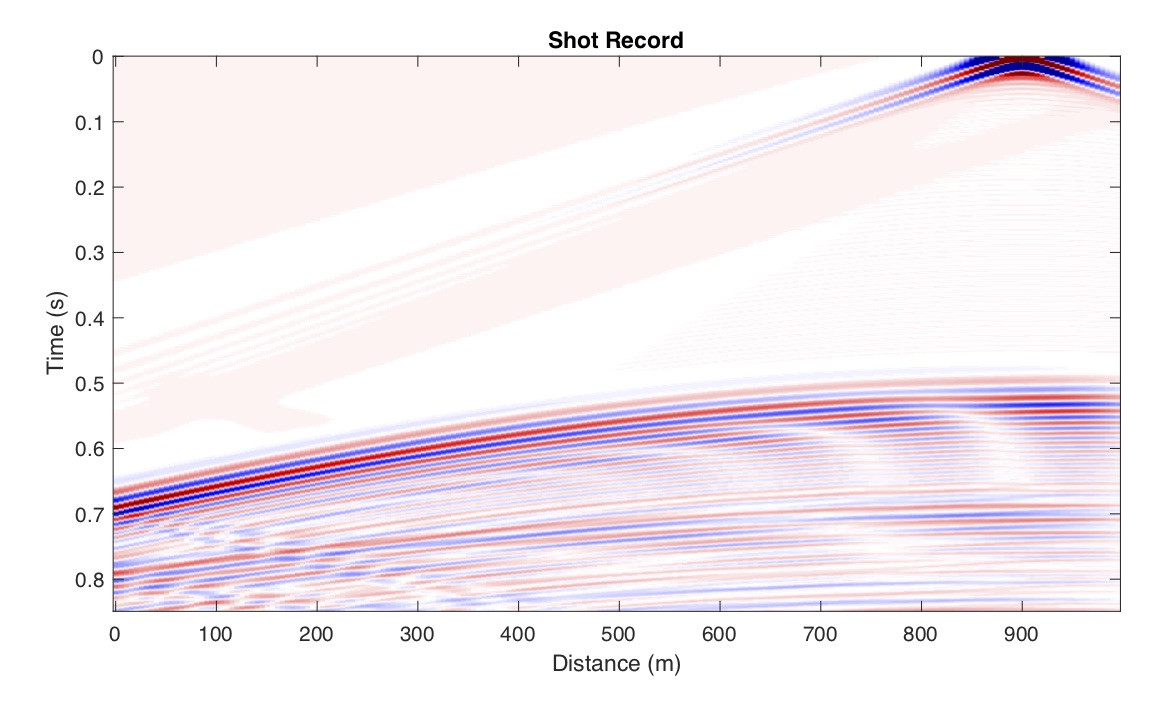

In [1]:

using Distributed
using Makie
using QuantEcon
using LinearAlgebra
using Interact

HTML{String}("    <script id=\"webio-setup-14834970169098915955\">\n    // Immediately-invoked-function-expression to avoid global variables.\n    (function() {\n        var warning_div = document.getElementById(\"webio-warning-6674099863150036250\");\n        var hide = function () {\n            var script = document.getElementById(\"webio-setup-14834970169098915955\");\n            var parent = script && script.parentElement;\n            var grandparent = parent && parent.parentElement;\n            if (grandparent) {\n                grandparent.style.display = \"none\";\n            }\n            warning_div.style.display = \"none\";\n        };\n        if (window.require && require.defined) {\n            // Jupyter notebook.\n            if (require.defined(\"nbextensions/webio/main\")\n                    || require.defined(\"/assetserver/6b0005d60e32e91e7decbd4817864b7214c8ae91-dist/main.js\")) {\n                // Extension already loaded.\n                hide();\n                return;\n            }\n            console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n            require([\"/assetserver/6b0005d60e32e91e7decbd4817864b7214c8ae91-dist/main.js\"], function (webIOModule) {\n                webIOModule.load_ipython_extension();\n            });\n            warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n        } else if (window.location.pathname.includes(\"/lab\")) {\n            // Guessing JupyterLab\n            warning_div.innerHTML = \"WebIO does not support JupyterLab yet.\";\n        }\n    })();\n    </script>\n    <div\n        id=\"webio-warning-6674099863150036250\"\n        class=\"output_text output_stderr\"\n        style=\"padding: 1em; font-weight: bold;\"\n    >\n        Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n        <!-- TODO: link to installation docs. -->\n    </div>\n")

In [2]:
addprocs(4)

4-element Array{Int64,1}:
 2
 3
 4
 5

In [3]:
Threads.nthreads()

4

# Forward Modelling

In [4]:
@everywhere function F2d(v,model,dx,nt,dt)
    (nz,nx)=size(model)
    #data=Array(Float64, nx,nt)
   data=zeros(nx,nt)
    fdm=zeros(nz,nx,3)
    
    #Boundary Absorbing Model
    iz=1:20 
    boundary = (exp.(-( (0.015 .* (20 .- iz)).^2 ) )).^10
    boundary = boundary'
    
    #Forward-T Modeling 
    fdm[:,:,2] = model;
    data[:,1]  = model[1,:];
    
    a = (v.*dt/dx).^2;    #wave equation coefficient
    b = 2 .-4 .*a;
    
    iz=2:(nz-1)
    ix=2:(nx-1)
    izb=1:nz-20
    
    snapshot=zeros(nz,nx,nt)
 for it=2:nt

    
  fdm[iz,ix,3]=b[iz,ix].*fdm[iz,ix,2]-fdm[iz,ix,1]+a[iz,ix].*(fdm[iz,ix.+1,2]+fdm[iz,ix.-1,2]+
            fdm[iz.+1,ix,2]+fdm[iz.-1,ix,2])
        
        fdm[iz,1,3] = b[iz,1].*fdm[iz,1,2] - fdm[iz,1,1] +
        a[iz,1].*(fdm[iz,2,2] + fdm[iz.+1,1,2] + fdm[iz.-1,1,2]);
        fdm[iz,nx,3] = b[iz,nx].*fdm[iz,nx,2] - fdm[iz,nx,1] +
        a[iz,nx].*(fdm[iz,nx.-1,2] + fdm[iz.+1,nx,2] +
        fdm[iz.-1,nx,2]);
  #      
        fdm[1,ix,3] = b[1,ix].*fdm[1,ix,2] -  fdm[1,ix,1] + 
        a[1,ix].*(fdm[2,ix,2] + fdm[1,ix.+1,2] + fdm[1,ix.-1,2]);
        fdm[nz,ix,3]= b[nz,ix].*fdm[nz,ix,2]- fdm[nz,ix,1] + 
        a[nz,ix].*(fdm[nz.-1,ix,2] + fdm[nz,ix.+1,2] + fdm[nz,ix.-1,2]);
        
        
        fdm[1 ,1 ,3] = b[1 , 1].*fdm[1 ,1 ,2] -fdm[1 ,1 ,1] + 
        a[1 , 1]*(fdm[2,1,2] + fdm[1,2,2]);
        fdm[nz,1 ,3] = b[nz, 1].*fdm[nz,1 ,2] -fdm[nz,1 ,1] + 
        a[nz, 1]*(fdm[nz,2,2] +fdm[nz.-1,1,2]);
        fdm[1 ,nx,3] = b[1 ,nx].*fdm[1 ,nx,2] -fdm[1 ,nx,1] + 
        a[1 ,nx]*(fdm[1,nx.-1,2] +fdm[2,nx,2]);
        fdm[nz,nx,3] = b[nz,nx].*fdm[nz,nx,2] -fdm[nz,nx,1] + 
        a[nz,nx]*(fdm[nz.-1,nx,2] +fdm[nz,nx.-1,2]);
                        
        fdm[:,:,1] = fdm[:,:,2];
        fdm[:,:,2] = fdm[:,:,3];
#        
   
     for ixb = 1:20
         fdm[izb,ixb,1] = boundary[ixb].*fdm[izb,ixb,1];
         fdm[izb,ixb,2] = boundary[ixb].*fdm[izb,ixb,2];
         ixb2 = nx.-20 .+ixb;
         fdm[izb,ixb2,1] = boundary[nx.-ixb2.+1].*fdm[izb,ixb2,1];
         fdm[izb,ixb2,2] = boundary[nx.-ixb2.+1].*fdm[izb,ixb2,2];
         izb2 = nz.-20 .+ixb;
         fdm[izb2,:,1] = boundary[nz.-izb2.+1].*fdm[izb2,:,1];
         fdm[izb2,:,2] = boundary[nz.-izb2.+1].*fdm[izb2,:,2];
    end
        data[:,it] = fdm[1,:,2];
        snapshot[:,:,it] = fdm[:,:,2];
    #data = data[21:end-20,:]';
    end 
    return snapshot, data
    end 
                            

In [5]:
function ricker(f,n,dt,t0,t1)



T = dt*(n-1);
t = 0:dt:T;
tau = t.-t0;

    (t1,t2) = meshgrid(tau,t.-t1);
 s = (1 .-(t1.^2+t2 .^2).*f^2 .*pi^2).*exp.(-(t1.^2+t2 .^2).*pi^2 .*f^2);
        rw = s;
    return rw,t
end

ricker (generic function with 1 method)

In [6]:
nz = 200; nx = 200;
dz = 5 ; dx = 5 ;
x = (0:nx-1)*dx;
z = (0:nz-1)*dz;

In [7]:

velo1 = 2000*ones(nz,nx);
velo1[Int(round(nz/2)):Int(round(nz/2)+4),Int(round(nx/2)):Int(round(nx/2)+4)] = ones(5,5).*3000;
(g,h)=size(velo1[Int(round(nz/2)):end,1:end] )
#velo[Int(round(nz/2)):end,1:end] = ones(g,h).*3000;

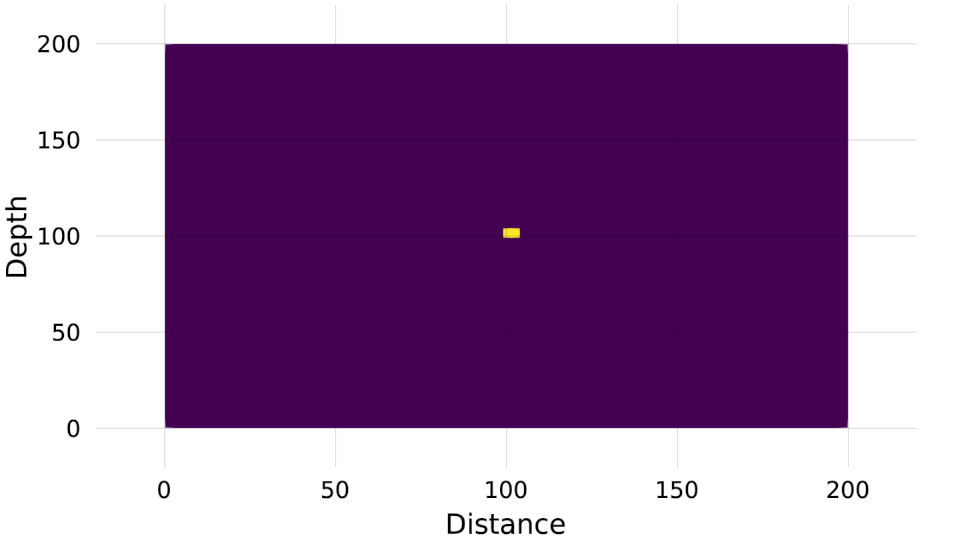

In [8]:
 scene = Scene()
 heatmap!(scene, velo1)
scene
 axis = scene[Axis] # get axis
 axis[:names][:axisnames] = ("Distance", "Depth")
scene

In [9]:
V=zeros(nz+20,nx+40)
V = [repeat(velo1[:,1],1,20) velo1 repeat(velo1[:,end],1,20)];
V = [V;(repeat(V[end,:],1,20))'];

In [10]:
# setup source function
dt = 0.9*minimum(minimum(dz./velo1/sqrt(2)));
vmin = minimum(velo1[:,:]);
nt = Int(round(sqrt((dx*nx)^2+(dz*nz)^2)/vmin/dt*1.2+1));
t = (0:nt-1)*dt;
f = 50;

In [11]:
    # initial wavefield
ixs=100   

(rw,t)=ricker(f,nz+40,dt,dt*ixs,0);
rw = rw[1:nz+20,:];
    #generate shot record
       snapshot1,data1= @time F2d(V,rw,dx,nt,dt);

  7.461243 seconds (5.53 M allocations: 5.941 GiB, 19.81% gc time)


using Interact
@manipulate for i=10:10:800
heatmap(snapshot[:,:,i])
end


@manipulate for ixs=1:20:200
    
(rw,t)=ricker(f,nz+40,dt,dt*ixs,0);

rw = rw[1:nz+20,:];
    
    #generate shot record
       snapshot,data= F2d(V,rw,dx,nt,dt);
@manipulate for i=10:10:800
heatmap(snapshot[:,:,i])
end
end



p1=heatmap(data[:,end:-1:1])
p2=heatmap(data[:,end:-1:1])
 pscene = AbstractPlotting.vbox(
     AbstractPlotting.hbox(p1, p2),
     sizes = [1, 1, 1])



scene = Scene();

heat = heatmap!(scene, x,z,snapshot[end:-1:1,:,1]')[end];
N = 800
scene
record(scene, "./Users/Slo0oH/Documents/Classes/animated_surface_and_wireframe.mp4",1:1:N) do i
    heat[3]=snapshot[end:-1:1,:,i]'
end

In [49]:
scene = Scene();
heat1 = surface!(scene, x,z,snapshot1[end:-1:1,:,1]')[end];
N = 500 
scene
record(scene, "./Documents/Classes/animated_surface_and_wireframe.mp4",1:1:N) do i
    heat1[3]=snapshot1[end:-1:1,:,i]'  
end 

ErrorException: failed process: Process(`ffmpeg -loglevel quiet -i '/var/folders/f1/rd9jgjwn3jgbfnyv0psw07480000gn/T/tmp39y39C/##video#366.mkv' -c:v libx264 -preset slow -crf 24 -pix_fmt yuv420p -c:a libvo_aacenc -b:a 128k -y ./Documents/Classes/animated_surface_and_wireframe.mp4`, ProcessExited(1)) [1]

In [13]:
  for k = 1:nt
    aux =  data1[:,k];
    amax = maximum((aux));
    data1[:,k] = data1[:,k]/amax;
   end

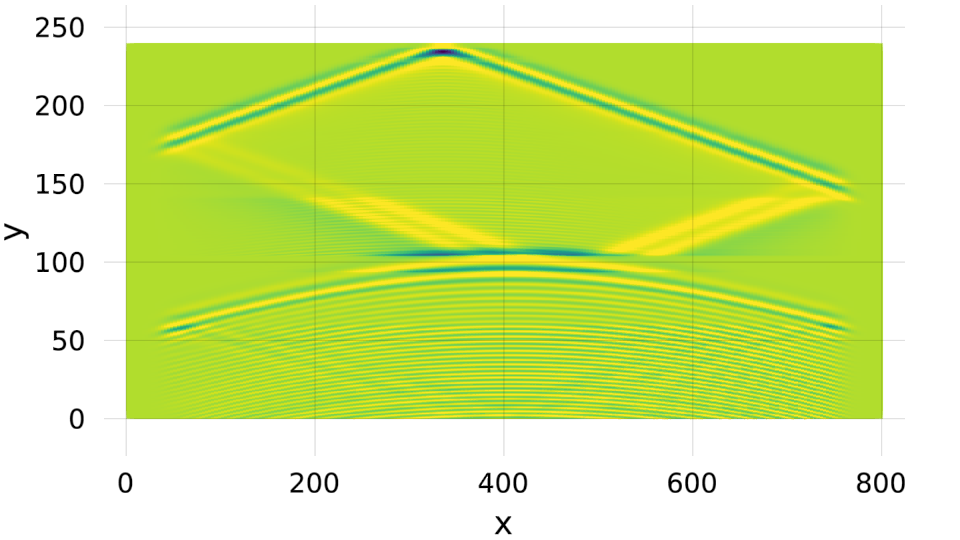

In [14]:
heatmap(data1[:,end:-1:1])

scene2 = Scene();
datas=zeros(nx+40,nt)

heat = heatmap!(scene2, x,z,datas[:,:])[end];
N = 800
scene2

record(scene2, "./docs/media/animated_surface_and_wireframe.mp4",2:1:N) do i
    
     datas=zeros(nx+40,nt)
     datas[:,1:i]=data[:,1:i];
     heat[3]=datas[:,:].*100
end



# Reverse-time Modelling  

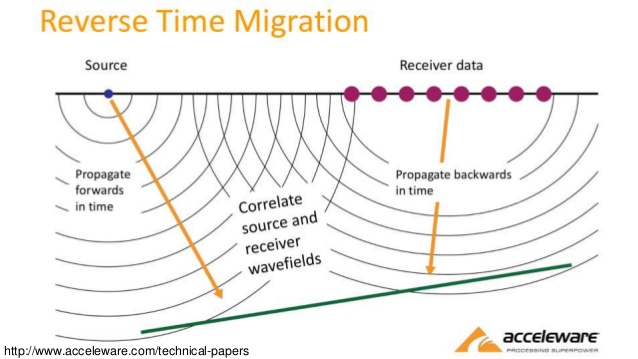

In [15]:
@everywhere function b2d(v,data,dx,nt,dt)
(nz,nx) = size(v);
(~,nt) = size(data);
fdm  = zeros(nz,nx,3);
    ss=zeros(nz,nx,3);
  
iz = 1:20;
boundary = (exp.(-( (0.015 .*(20 .-iz)).^2 ) )).^10;
    
fdm[1,:,1] = data[:,nt];
fdm[1,:,2] = data[:,nt-1];
fdm[1,:,3] = data[:,nt-2];
    
a = (v .* dt/dx) .^2;    
b = 2 .- 4 .* a;

    
ix   = 2:nx-1;       
ixb  = 1:20;         
ixb2 = nx-19:nx;
    
cz = 3;
   
snapshot = zeros(nz,nx,nt);

       for it = (nt-1):-1:1
    cz = cz .+1;
    bz = min(cz,nz);
        
        for iz = 1:bz
        fdm[iz,ixb,1] = boundary.*fdm[iz,ixb,1];
        fdm[iz,ixb,2] = boundary.*fdm[iz,ixb,2];
        fdm[iz,ixb2,1] = boundary[end:-1:1].*fdm[iz,ixb2,1];
        fdm[iz,ixb2,2] = boundary[end:-1:1].*fdm[iz,ixb2,2];
           
    end
    
            if bz >= (nz-19)
        for iz = nz-19:bz
            fdm[iz,:,1] = boundary[nz.-iz.+1].*fdm[iz,:,1];
            fdm[iz,:,2] = boundary[nz.-iz.+1].*fdm[iz,:,2];
        end
    end
        
         if bz == nz
        ez = nz .-1;
    else
        ez = bz;
    end
        
        
            iz = 1:bz;
    fdm[iz,ix,3] = fdm[iz,ix,3] - fdm[iz,ix,1];
   
    iz = 2:ez;
    fdm[iz,ix,2] = b[iz,ix].*fdm[iz,ix,1] + fdm[iz,ix,2] + a[iz,ix.+1].*fdm[iz,ix.+1,1] + 
        a[iz,ix.-1].*fdm[iz,ix.-1,1]+ a[iz.+1,ix].*fdm[iz.+1,ix,1] + a[iz.-1,ix].*fdm[iz.-1,ix,1];
    
  
    fdm[1,ix,2] = b[1,ix].*fdm[1,ix,1] + fdm[1,ix,2]+ a[1,ix.+1].*fdm[1,ix.+1,1] +
        a[1,ix.-1].*fdm[1,ix.-1,1]+ a[2,ix].*fdm[2,ix,1];
    
 
    if bz == nz
    
            
        fdm[nz,ix,2] = b[nz,ix,1].*fdm[nz,ix,1] + fdm[nz,ix,2] + a[nz,ix.+1].*fdm[nz,ix.+1,1] +
            a[nz,ix.-1].*fdm[nz,ix.-1,1] + a[nz.-1,ix].*fdm[nz.-1,ix,1];
        

        fdm[nz,1,2] = b[nz,1,1].*fdm[nz,1,1] + fdm[nz,1,2] +
            a[nz,2,1].*fdm[nz,2,1] + a[nz.-1,1,1].*fdm[nz.-1,1,1];
    end
    
    fdm[iz,1,2] = b[iz,1,1].*fdm[iz,1,1] + fdm[iz,1,2]+
        a[iz,2].*fdm[iz,2,1]+ a[iz.+1,1].*fdm[iz.+1,1,1] +
        a[iz.-1,1].*fdm[iz.-1,1,1];
    
    fdm[iz,nx,2] = b[iz,nx,1].*fdm[iz,nx,1] + fdm[iz,nx,2] + a[iz,nx.-1].*fdm[iz,nx.-1,1]+
        a[iz.+1,nx].*fdm[iz.+1,nx,1] + a[iz.-1,nx].*fdm[iz.-1,nx,1];
    

    fdm[1,1,2] = b[1,1,1].*fdm[1,1,1] + fdm[1,1,2]+
        a[1,2,1].*fdm[1,2,1] + a[2,1,1].*fdm[2,1,1];
    
  
    fdm[1,nx,2] = b[1,nx,1].*fdm[1,nx,1] + fdm[1,nx,2] +
        a[1,nx.-1,1].*fdm[1,nx.-1,1] + a[2,nx,1].*fdm[2,nx,1];
    

    fdm[:,:,1] = fdm[:,:,2];
    fdm[:,:,2] = fdm[:,:,3];
    
  
    if it > 2
        fdm[2:nz,:,3] = zeros(nz-1,nx);
        fdm[1,:,3] = data[:,it-2];
    end  
    
    snapshot[:,:,it] = fdm[:,:,1];
        end 
    model = fdm[:,:,1];
    return snapshot,model
    end 
        

In [16]:
nz = Int(200); nx = Int(200);
dz = 10 ; dx = 10 ;
x = (0:nx-1)*dx;
z = (0:nz-1)*dz;


In [17]:
velo=zeros(nz,nx)
velo = 2000 .*ones(nz,nx);
velo[Int(round(nz/2)):Int(round(nz/2)+4),Int(round(nx/2)):Int(round(nx/2)+4)] = ones(5,5).*3000;
velo_const = 2000 .*ones(nz,nx);        
#velo[51:end,1:end] = 3000*ones(50,nx);
#velo[76:end,1:end] = 4000*ones(25,nx);

In [18]:
V = [repeat(velo[:,1],1,20) velo repeat(velo[:,end],1,20)];
V = [V;(repeat(V[end,:],1,20))'];

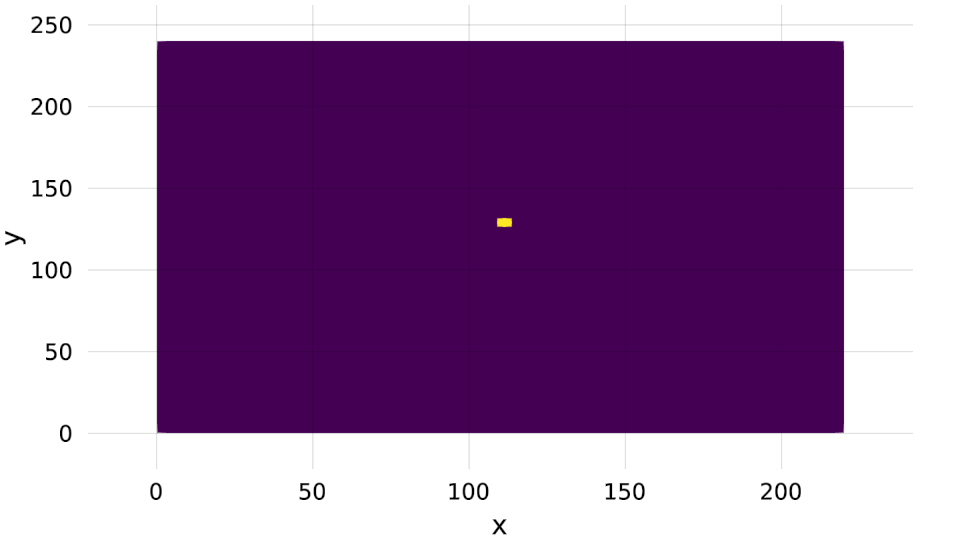

In [19]:
heatmap(V[end:-1:1,:]')

In [20]:
Vc = [repeat(velo_const[:,1],1,20) velo_const repeat(velo_const[:,end],1,20)];
Vc = [Vc;(repeat(Vc[end,:],1,20))'];

In [21]:
# setup source function
dt = 0.9*minimum(minimum(dz./velo/sqrt(2)));
vmin = minimum(velo[:,:]);
nt = Int(round(sqrt((dx*nx)^2+(dz*nz)^2)/vmin/dt+1));
t = (0:nt-1)*dt;
f = 1000;

In [22]:
nt

668

In [23]:

data = zeros(size(nt,nx));
snapshot_i = zeros(nz+20,nx+40,nt);
#snapshot_d = zeros(nz+20,nx+40,nt);
#snapshot_c = zeros(nz+20,nx+40,nt);
images = zeros(nz+20,nx+40);

#for ixs=1:10:100;
 ixs=100  
    (rw,t) = ricker(f,nz+40,dt,dt*ixs,0);
    rw = rw[1:nz+20,:];
    
 

  
    (snapshot_s,data) = F2d(V,rw,dx,nt,dt);
      ( snapshot_c,data_const) = F2d(Vc,rw,dx,nt,dt);
  
    
 data_refl = data .- data_const;


   @time    (snapshot_d,fdm) = b2d(Vc,data_refl,dx,nt,dt);
    
   
      for i = 1:nt
        snapshot_i[:,:,i] = snapshot_c[:,:,i] .* snapshot_d[:,:,i];
    end
   i=2
for i = 2:nt
        snapshot_i[:,:,i] = snapshot_i[:,:,i] .+ snapshot_i[:,:,i.-1];
    end
    images = images .+ snapshot_i[:,:,end];

#end

  8.482021 seconds (4.67 M allocations: 6.214 GiB, 14.72% gc time)


using SharedArrays

using DistributedArrays
a = SharedArray{Float64}(10)
@distributed for i = 1:10
    a[i] = i
end

In [50]:
scene = Scene();

heat = heatmap!(scene, x,z,snapshot_c[end:-1:1,:,1]')[end];
N = 200
scene
record(scene, "./docs/media/animated_surface_and_wireframe.mp4",1:1:N) do i
    heat[3]=snapshot_c[end:-1:1,:,i]'
end



ErrorException: failed process: Process(`ffmpeg -loglevel quiet -i '/var/folders/f1/rd9jgjwn3jgbfnyv0psw07480000gn/T/tmp2Tu1jq/##video#368.mkv' -c:v libx264 -preset slow -crf 24 -pix_fmt yuv420p -c:a libvo_aacenc -b:a 128k -y ./docs/media/animated_surface_and_wireframe.mp4`, ProcessExited(1)) [1]

In [51]:
scene = Scene();

heat = heatmap!(scene, x,z,snapshot_d[end:-1:1,:,1]')[end];
N = 200
scene
record(scene, "./docs/media/animated_surface_and_wireframe.mp4",1:1:N) do i
    heat[3]=snapshot_d[end:-1:1,:,i]'
end

ErrorException: failed process: Process(`ffmpeg -loglevel quiet -i '/var/folders/f1/rd9jgjwn3jgbfnyv0psw07480000gn/T/tmpU8AEgF/##video#369.mkv' -c:v libx264 -preset slow -crf 24 -pix_fmt yuv420p -c:a libvo_aacenc -b:a 128k -y ./docs/media/animated_surface_and_wireframe.mp4`, ProcessExited(1)) [1]

In [52]:
scene = Scene();

heat = heatmap!(scene, x,z,snapshot_i[end:-1:1,:,1]')[end];
N = 400
scene
record(scene, "./docs/media/animated_surface_and_wireframe.mp4",1:1:N) do i
    heat[3]=snapshot_i[end:-1:1,:,i]'
end

ErrorException: failed process: Process(`ffmpeg -loglevel quiet -i '/var/folders/f1/rd9jgjwn3jgbfnyv0psw07480000gn/T/tmplz9UFs/##video#370.mkv' -c:v libx264 -preset slow -crf 24 -pix_fmt yuv420p -c:a libvo_aacenc -b:a 128k -y ./docs/media/animated_surface_and_wireframe.mp4`, ProcessExited(1)) [1]

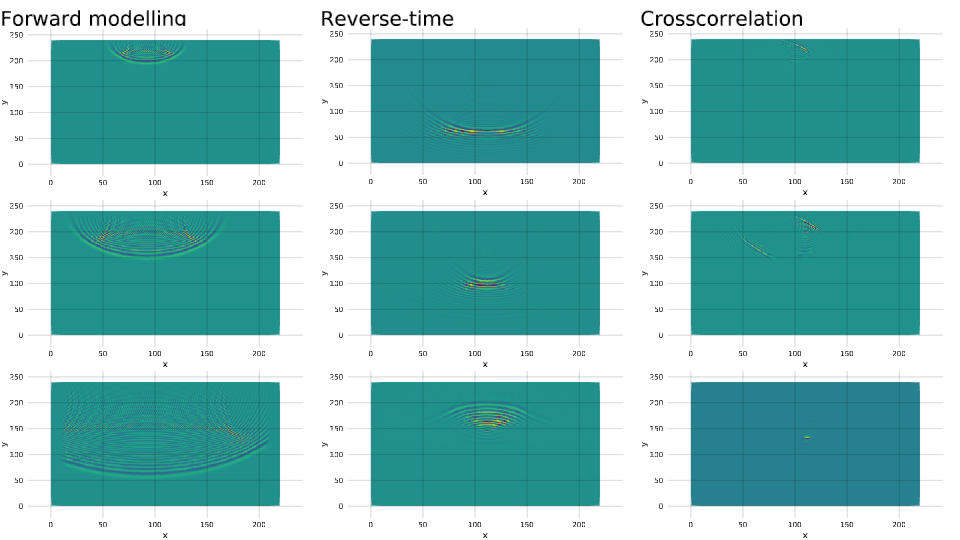

In [27]:
p1 = heatmap(snapshot_c[end:-1:1,:,100]')
p2 = heatmap(snapshot_d[end:-1:1,:,100]')
p3 = heatmap(snapshot_i[end:-1:1,:,100]')
p4 = heatmap(snapshot_c[end:-1:1,:,200]')
p5 = heatmap(snapshot_d[end:-1:1,:,200]')
p6 = heatmap(snapshot_i[end:-1:1,:,200]')
p7 = heatmap(snapshot_c[end:-1:1,:,400]')
p8 = heatmap(snapshot_d[end:-1:1,:,400]')
p9 = heatmap(snapshot_i[end:-1:1,:,400]')
 t = Theme(align = (:left, :bottom), raw = true, camera = campixel!)
 title1 = text(t, "Forward modelling")
 title2 = text( t,"Reverse-time")
 title3 = text( t,"Crosscorrelation")
 pscene = AbstractPlotting.vbox(AbstractPlotting.hbox(p7,p4,p1,title1), AbstractPlotting.hbox(p8,p5,p2,title2),
    AbstractPlotting.hbox(p9,p6,p3,title3) 
 )

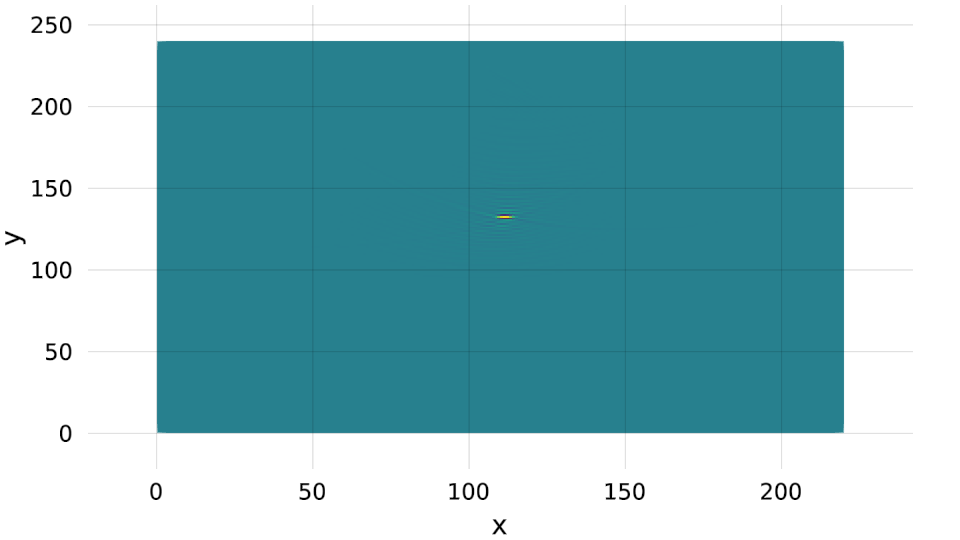

In [29]:
heatmap(images[end:-1:1,:]')

In [30]:
using Images, Interact

download("https://upload.wikimedia.org/wikipedia/commons/6/69/Julia_prog_language.svg")

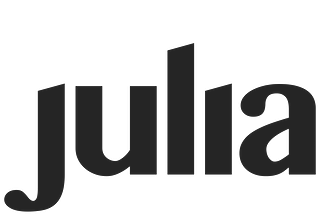

In [31]:
julia = load("julia.png")

In [32]:
julia_array = float.(channelview(julia));

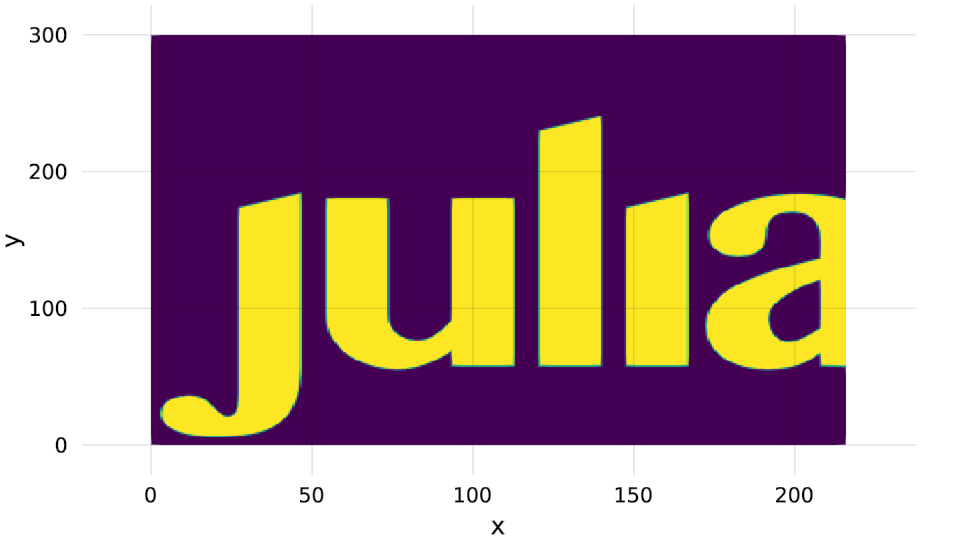

In [33]:
heatmap(julia_array[4,216:-1:1,1:300]'.+1000)

In [34]:
VV=ones(300,300).*2000;
VV[40:255,1:300]=julia_array[1,1:216,1:300].*9000 .+2000;

#VVjulia_array[1,1:200,100:300].*9000 .+2000;

In [35]:
using LinearAlgebra

In [36]:
velo=VV;
nz = 300; nx = 300;
dz = 20 ; dx = 20 ;
x = (0:nx-1)*dx;
z = (0:nz-1)*dz;

V=zeros(nz+20,nx+40)
V = [repeat(velo[:,1],1,20) velo repeat(velo[:,end],1,20)];
V = [V;(repeat(V[end,:],1,20))'];

dt = 0.9*minimum(minimum(dz./velo/sqrt(2)));

vmin = minimum(velo[:,:]);
nt = Int(round(sqrt((dx*nx)^2+(dz*nz)^2)/vmin/dt+1));

t = (0:nt-1)*dt;
f = 50;

In [37]:
nt

1421

In [38]:
dt

0.0029886003429301236

In [39]:
ixs=160
(rw,t)=ricker(f,nz+40,dt,dt*ixs,0);
rw = rw[1:nz+20,:];
    
    #generate shot record
       snapshot,data2= F2d(V,rw,dx,nt,dt);

In [53]:
scene = Scene();

heat = heatmap!(scene, x,z,snapshot[end:-1:1,:,1]')[end];
N = 600
scene
record(scene, "./docs/media/animated_surface_and_wireframe.mp4",1:1:N) do i
    heat[3]=snapshot[end:-1:1,:,i]'
end



ErrorException: failed process: Process(`ffmpeg -loglevel quiet -i '/var/folders/f1/rd9jgjwn3jgbfnyv0psw07480000gn/T/tmpF1BdHv/##video#371.mkv' -c:v libx264 -preset slow -crf 24 -pix_fmt yuv420p -c:a libvo_aacenc -b:a 128k -y ./docs/media/animated_surface_and_wireframe.mp4`, ProcessExited(1)) [1]

In [41]:
   for k = 1:nt
    aux =  data2[:,k];
    amax = maximum((aux));
    data2[:,k] = data2[:,k]/amax;
   end

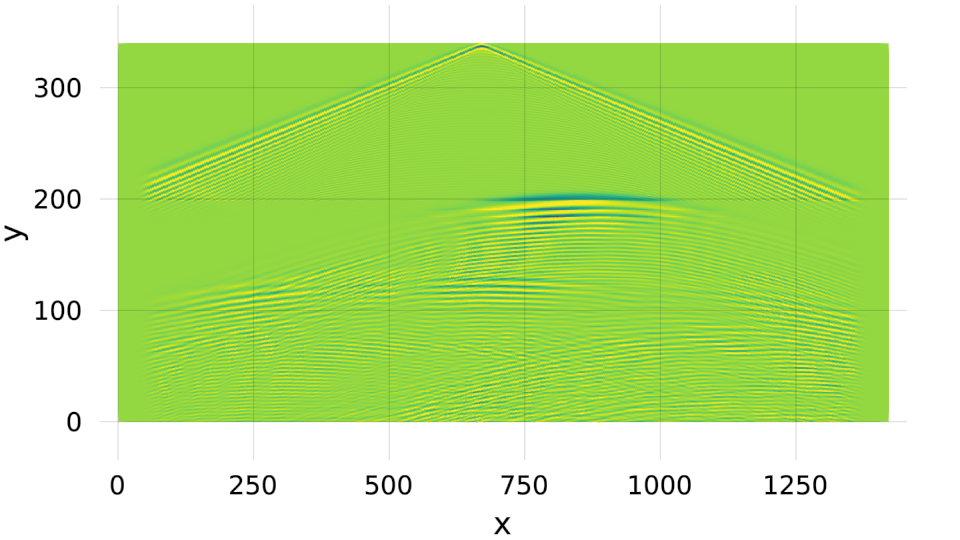

In [42]:
heatmap(data2[:,end:-1:1])

In [43]:
velo2=VV;
nz = 300; nx = 300;
dz = 10 ; dx = 10 ;
x = (0:nx-1)*dx;
z = (0:nz-1)*dz;
#velo=zeros(nz,nx)
#velo = 2000 .*ones(nz,nx);
velo_const = 2000 .*ones(nz,nx);        
#velo[151:end,1:end] = 3000*ones(50,nx);
#velo_const = 2000 .*ones(nz,nx);        
V = [repeat(velo2[:,1],1,20) velo2 repeat(velo2[:,end],1,20)];
V = [V;(repeat(V[end,:],1,20))'];

Vc = [repeat(velo_const[:,1],1,20) velo_const repeat(velo_const[:,end],1,20)];
Vc = [Vc;(repeat(Vc[end,:],1,20))'];

dt = 0.9*minimum(minimum(dz./velo2/sqrt(2)));
vmin = minimum(velo2[:,:]);
nt = Int(round(sqrt((dx*nx)^2+(dz*nz)^2)/vmin/dt+1));
t = (0:nt-1)*dt;
f = 1000;

data = zeros(size(nt,nx));
snapshot_i = zeros(nz+20,nx+40,nt);
images = zeros(nz+20,nx+40);

for ixs=1:2;
   data = zeros(size(nt,nx));
    (rw,t) = ricker(f,nz+40,dt,dt*ixs,0);
    rw = rw[1:nz+20,:];
    
 

  
    (snapshot_s,data) = F2d(V,rw,dx,nt,dt);
    ( snapshot_c,data_const) = F2d(Vc,rw,dx,nt,dt);
end

In [44]:
nt

1421

In [45]:


data = zeros(size(nt,nx));
snapshot_i2 = zeros(nz+20,nx+40,nt);
images2 = zeros(nz+20,nx+40);

for ixs=10:60:300;
    k=1
    data = zeros(size(nt,nx));
    (rw,t) = ricker(f,nz+40,dt,dt*ixs,0);
    rw = rw[1:nz+20,:];
    
 

  
    (snapshot_s,data) = F2d(V,rw,dx,nt,dt);
    ( snapshot_c,data_const) = F2d(Vc,rw,dx,nt,dt);
  
    
 data_refl = data .- data_const;


   @time    (snapshot_d,fdm) = b2d(Vc,data_refl,dx,nt,dt);
    
   
      for i = 1:nt
        snapshot_i2[:,:,i] = snapshot_c[:,:,i] .* snapshot_d[:,:,i];
    end
   i=2
for i = 2:nt
        snapshot_i2[:,:,i] = snapshot_i2[:,:,i] .+ snapshot_i2[:,:,i.-1];
    end
    images2 = images2 .+ snapshot_i2[:,:,end];
    

end

 14.660721 seconds (4.39 M allocations: 27.352 GiB, 22.85% gc time)
 14.581719 seconds (4.39 M allocations: 27.352 GiB, 22.69% gc time)
 14.266719 seconds (4.39 M allocations: 27.352 GiB, 22.30% gc time)
 14.367201 seconds (4.39 M allocations: 27.352 GiB, 22.61% gc time)
 14.357399 seconds (4.39 M allocations: 27.352 GiB, 22.35% gc time)


In [54]:
scene = Scene();

heat = heatmap!(scene, x,z,snapshot_i2[end:-1:1,:,1]')[end];
N = 1000
scene
record(scene, "./docs/media/animated_surface_and_wireframe.mp4",1:1:N) do i
    heat[3]=snapshot_i2[end:-1:1,:,i]'
end

ErrorException: failed process: Process(`ffmpeg -loglevel quiet -i '/var/folders/f1/rd9jgjwn3jgbfnyv0psw07480000gn/T/tmpHzIJqA/##video#372.mkv' -c:v libx264 -preset slow -crf 24 -pix_fmt yuv420p -c:a libvo_aacenc -b:a 128k -y ./docs/media/animated_surface_and_wireframe.mp4`, ProcessExited(1)) [1]

In [47]:
   for k = 1:nx
    aux =  images2[:,k];
    amax = maximum((aux));
    images2[:,k] = images2[:,k]/amax;
   end

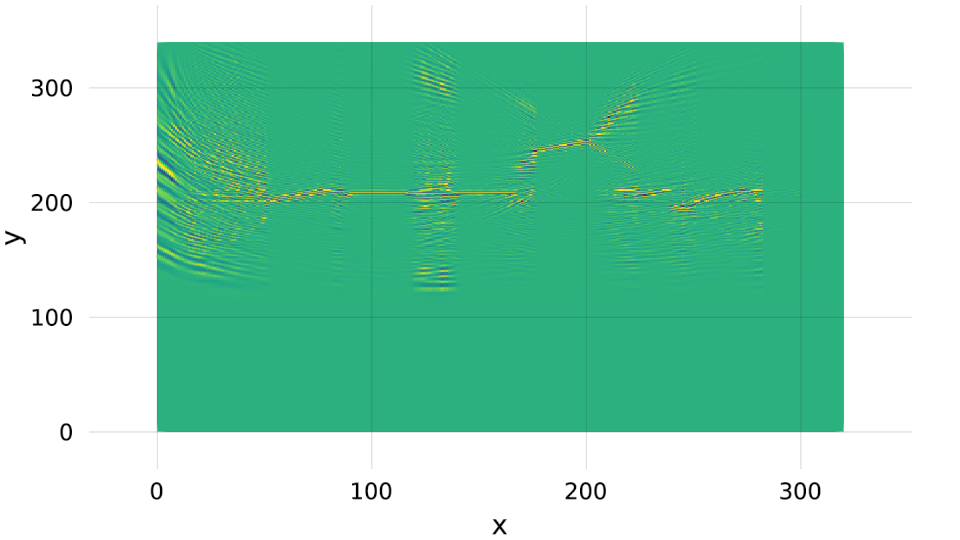

In [48]:
heatmap(images2[end:-1:1,:,1]')

# References

- Jones, I.F.. (2014). Tutorial: Migration imaging conditions. First Break. 32. 45-55. 10.3997/1365-2397.2014017. 
- Jiang, Z, Bancroft, J, Lines, L (2010). Reverse-Timve Migration Imaging With/without Multiples. CREWES Research Report. Volume 22. 